# Introduction to the PL/pgSQL Exception clause

When an error occurs within a block, PostgreSQL will abort the execution of that block as well as the surrounding transaction.

To recover from the error, you can use the `exception` clause in the `begin...end` block.

Here’s the syntax of the `exception` clause:

```postgresql
<<label>>
declare
   ...
begin
    ...
exception
    when condition [or condition...] then
       handle_exception;
   [when condition [or condition...] then
       handle_exception;]
   [when others then
       handle_other_exceptions;
   ]
end; 
```

**How it works.**
* First, when an error occurs between the `begin` and `exception` clause, PL/pgSQL stops the execution and passes the control to the `exception` section.
* Second, PL/pgSQL sequentially searches for the first `condition` that matches the error.
* Third, if there is a match, the corresponding `handle_exception` statements will execute, and the control is passed to the statement after the `end` keyword.
* Finally, if no match is found, the error propagates out and can be caught by the `exception` clause of the enclosing block. If there is no enclosing block with the `exception` clause, PL/pgSQL will abort the processing.

The condition names can be `no_data_found` in case of a `select` statement that returns no rows or `too_many_rows` if the `select` statement returns more than one row. *For a complete list of condition names on the PostgreSQL website.*

It’s also possible to specify the error condition by `SQLSTATE` code. For example, `P0002` for `no_data_found` and `P0003` for `too_many_rows`.

Typically, you will catch a specific exception and handle it properly.

To handle other exceptions rather than the ones on the list, you can use the `when others then` clause.

# Handling exception examples

We’ll use the `film` table from the sample database for the demonstration.

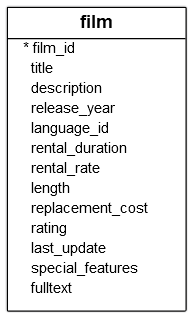

## 1) Handling no_data_found exception example

**The following example issues an error because the film id 2000 does not exist.**

```postgresql
do
$$
declare
	rec record;
	v_film_id int = 2000;
begin
	-- select a film
	select film_id, title
	into strict rec
	from film
	where film_id = v_film_id;
end;
$$
language plpgsql; 
```

**Output:**

```
ERROR:  query returned no rows
CONTEXT:  PL/pgSQL function inline_code_block line 6 at SQL statement
SQL state: P0002
```

**The following example uses the `exception` clause to catch the no_data_found` exception and report a more meaningful message:**

```postgresql
do
$$
declare
	rec record;
	v_film_id int = 2000;
begin
	-- select a film
	select film_id, title
	into strict rec
	from film
	where film_id = v_film_id;
        -- catch exception
	exception
	   when no_data_found then
	      raise exception 'film % not found', v_film_id;
end;
$$; 
```

**Output:**

```
ERROR:  film 2000 not found
CONTEXT:  PL/pgSQL function inline_code_block line 14 at RAISE
SQL state: P0001
```

## 2) Handling too_many_rows exception example

**The following example illustrates how to handle the `too_many_rows` exception:**

```postgresql
do
$$
declare
	rec record;
begin
	-- select film
	select film_id, title
	into strict rec
	from film
	where title LIKE 'A%';

	exception
	   when too_many_rows then
	      raise exception 'Search query returns too many rows';
end;
$$; 
```

**Output:**

```
ERROR:  Search query returns too many rows
CONTEXT:  PL/pgSQL function inline_code_block line 15 at RAISE
SQL state: P0001
```

In this example, the `too_many_rows` exception occurs because the `select into` statement returns more than one row while it is supposed to return one row.

## 3) Handling multiple exceptions

The following example illustrates how to catch multiple exceptions:

```postgresql
do
$$
declare
	rec record;
	v_length int = 90;
begin
	-- select a film
	select film_id, title
	into strict rec
	from film
	where length = v_length;

        -- catch exception
	exception
	   when sqlstate 'P0002' then
	      raise exception 'film with length % not found', v_length;
	   when sqlstate 'P0003' then
	      raise exception 'The with length % is not unique', v_length;
end;
$$; 
```

**Output:**

```
ERROR:  The with length 90 is not unique
CONTEXT:  PL/pgSQL function inline_code_block line 17 at RAISE
SQL state: P0001
```


## 4) Handling exceptions as SQLSTATE codes

**The following example is the same as the one above except that it uses the `SQLSTATE` codes instead of the condition names:**

```postgresql
do
$$
declare
	rec record;
	v_length int = 30;
begin
	-- select a film
	select film_id, title
	into strict rec
	from film
	where length = v_length;

        -- catch exception
	exception
	   when sqlstate 'P0002' then
	      raise exception 'film with length % not found', v_length;
	   when sqlstate 'P0003' then
	      raise exception 'The with length % is not unique', v_length;
end;
$$; 
```

**Output:**

```
ERROR:  film with length 30 not found
CONTEXT:  PL/pgSQL function inline_code_block line 15 at RAISE
SQL state: P0001
```